In [2]:
import pandas as pd 
import numpy as np
import uuid
import networkx as nx
import random
from collections import defaultdict
from tqdm.notebook import tqdm
import pylab as plt
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

In [3]:
COUNT_OF_TASKS = 10
COUNT_OF_BIG_TASKS = 2

PROBABILY_OF_EDGE = 0.02

In [238]:
COUNT_FREE_MOVE_FORWARD_TASKS = 0.1
COUNT_NOT_MOVE_FORWARD_TASKS = 0 #0.2
COUNT_PRICE_MOVE_FORWARD_TASKS = 0.7
MAX_PRICE_MOVE_FORWARD = 100

In [525]:
MIN_DURATION = 0
MAX_DURATION = 20 #10

MAX_DAYS_DELAY = 10#1

In [6]:
class Task:
    def __init__(self, id, name, start_date, price_move_backward, price_move_forward, duration, min_duration, price_min_duration,  is_big=False):
        self.is_big = is_big
        if is_big: # is_big это типа флаг является ли вехой
            duration = 0
            min_duration = 0
            price_min_duration = -1
        self.id = id
        self.name = name
        self.start_date = start_date
        self.price_move_backward = price_move_backward
        self.price_move_forward = price_move_forward
        self.duration = duration
        self.min_duration = min_duration
        self.price_min_duration = price_min_duration
        self.is_big = is_big
        self.finish_date = start_date + duration
        
    
    def set_duration(self, duration):
        if self.is_big:
            return
        self.duration = duration
        
    def set_min_duration(self, min_duration):
        if self.is_big:
            return
        self.min_duration = min_duration
        
        
    def to_array(self):
        return [self.id, self.name, self.start_date, self.price_move_backward, self.price_move_forward, self.duration,
                self.min_duration, self.price_min_duration, self.is_big]

In [7]:
def get_price_move_forward():
    p = np.random.random()
    if 0 <= p <= COUNT_FREE_MOVE_FORWARD_TASKS:
        return 0
    if COUNT_FREE_MOVE_FORWARD_TASKS < p <= COUNT_NOT_MOVE_FORWARD_TASKS + COUNT_FREE_MOVE_FORWARD_TASKS:
        return -1
    return np.random.randint(MAX_PRICE_MOVE_FORWARD)

In [8]:
def get_price_move_forward_big():
    tmp = get_price_move_forward()
    while tmp <= 0:
        tmp = get_price_move_forward()
    return tmp * 1000

In [9]:
def get_task_type():
    p = np.random.random()
    if p <= COUNT_OF_BIG_TASKS / (COUNT_OF_TASKS + COUNT_OF_BIG_TASKS):
        return True
    return False

In [10]:
def get_price_move_backward():
    return get_price_move_forward()

In [11]:
def get_price_min_duration():
    p = np.random.random()
    if 0 <= p <= COUNT_FREE_MOVE_FORWARD_TASKS:
        return 0
    if COUNT_FREE_MOVE_FORWARD_TASKS < p <= COUNT_NOT_MOVE_FORWARD_TASKS + COUNT_FREE_MOVE_FORWARD_TASKS:
        return -1
    return np.random.randint(MAX_PRICE_MOVE_FORWARD) * np.random.randint(2, 5)

In [12]:
def get_random_task():
    is_big = get_task_type()
    if is_big:  
        price_move_forward = get_price_move_forward_big()
    else:
        price_move_forward = get_price_move_forward()
    
    price_move_backward = get_price_move_backward()
    start_date = 0
    duration = 0
    price_min_duration = get_price_min_duration()
    min_duration = 0
    name = str(uuid.uuid4())
    id = name
    task = Task(id, name, start_date, price_move_backward, price_move_forward, duration, min_duration, price_min_duration, is_big)
    
    return task

In [ ]:
         price_move_forward      min_duration   price_min_duration     is_big
22 -1 -1 3                       0              288                    False

In [13]:
def get_duration():
    return np.random.randint(MIN_DURATION, MAX_DURATION + 1)

In [14]:
def get_min_duration(duration):
    if duration == 0:
        return 0
    return np.random.randint(0, duration)

In [15]:
def get_delay():
    return np.random.randint(MAX_DAYS_DELAY + 1)

In [551]:
g = nx.DiGraph()
anti_g = nx.DiGraph()

COUNT = COUNT_OF_TASKS + COUNT_OF_BIG_TASKS
COUNT = 10000

USE_WEIGHTS = True
PROBABILY_OF_EDGE = 0.07

for i in tqdm(range(int(COUNT))):
    #count_of_edges = int(np.random.random() * PROBABILY_OF_EDGE * (COUNT - i))
    edges = [x for x in range(i + 1, COUNT + 1) if np.random.random() <= PROBABILY_OF_EDGE]
    if len(edges) == 0:
        edges = [np.random.randint(i + 1, COUNT + 1)]
    #if count_of_edges == 0:
    #    count_of_edges = 1
    #count_of_edges = 1
#     if USE_WEIGHTS:
#         edges = random.choices(range(i + 1, COUNT + 1), weights = range(COUNT + 1, i + 1, -1), k=count_of_edges)
#     else:
#         edges = random.choices(range(i + 1, COUNT + 1), k=count_of_edges)
    g.add_edges_from([(i, x) for x in  edges])
    anti_g.add_edges_from([(x, i) for x in  edges])
    
print(len(g.nodes), len(g.edges))
#sum([abs(a - b)  for a, b in g.edges]) / COUNT


10001 3497961


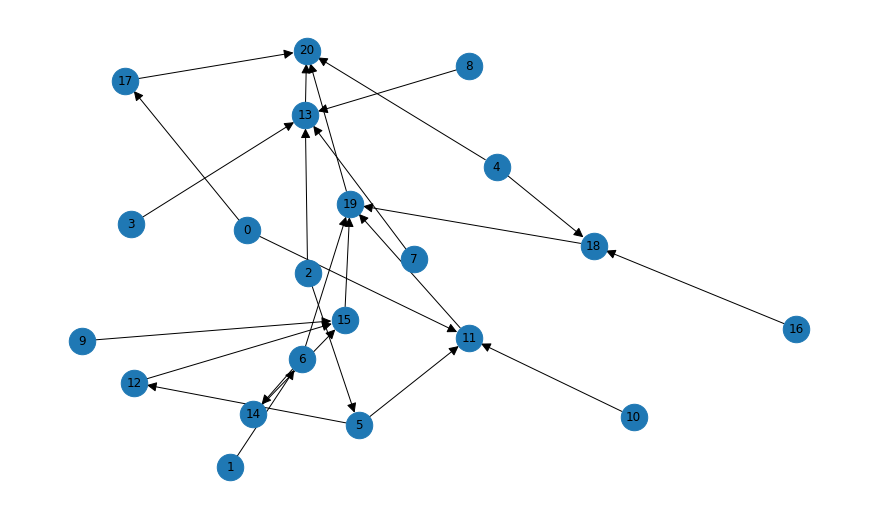

In [550]:
plt.figure(figsize=(12,7)) 
nx.draw(g, with_labels=True, node_size=700, arrowsize =20, pos=nx.spring_layout(g))
plt.show()

In [552]:
tasks = defaultdict(int)

all_tasks = []
for node in tqdm(nx.topological_sort(g)):
    neighbors = list(anti_g.neighbors(node))
    if neighbors:
        min_date = tasks[max(neighbors, key=lambda x: tasks[x])]
    else:
        min_date = 1
    duration = get_duration()
    min_duration = get_min_duration(duration)
    delay = get_delay()
    
    
    start_date = min_date + delay
    
    task = get_random_task()
    task.set_duration(duration)
    task.set_min_duration(min_duration)
    
    duration = task.duration
    min_duration = task.duration
    
    tasks[node] = start_date + duration
    task.start_date = start_date
    task.finish_date = start_date + duration
    
    
    task.id = node
    task.name = get_name().replace(' ', '_')
    all_tasks.append(task)

In [532]:
with open('input.txt', 'w') as file:
    file.write(str(len(all_tasks)) + '\n')
    for task in all_tasks:
        file.write(' '.join(map(str, task.to_array())) + '\n')
    file.write(str(len(g.edges)) + '\n')
    for a, b in g.edges:
        file.write(str(a) + ' ' + str(b) + '\n')

In [489]:
arr = []
for task in all_tasks[:-1]:
    arr.append(task.to_array())
df = pd.DataFrame(arr)
df.columns = ['id', 'Имя', 'Дата старта', 'Штраф за сдвиг назад', 'Штраф за сдвиг впредед', 'Длительность', 'Минимальная длительность', 'Цена за минимальную длительность', 'Веха']
df

,id,Имя,Дата старта,Штраф за сдвиг назад,Штраф за сдвиг впредед,Длительность,Минимальная длительность,Цена за минимальную длительность,Веха
0,598790,d0e359ad-a863-440f-98f0-c416289068f1,2,81,0,22,18,0,False
1,598537,8616d97b-621f-432f-a383-242157e3d1dd,2,88,1000,0,0,-1,True
2,598208,003c6053-fbdb-4e89-8d15-a8f802423a35,5,28,63,111,73,196,False
3,598052,61b244c9-21dd-4ff3-a50d-0115cd959b5a,3,26,0,84,75,213,False
4,597955,b15a9d7d-cb7a-4b48-912f-7e77d9d7a022,2,83,0,31,17,4,False
...,...,...,...,...,...,...,...,...,...
599995,599805,38a76f20-3522-4e88-ace1-baa704a31e7f,1357,46,19000,0,0,-1,True
599996,599940,34ab2325-ef84-4ecd-a6be-8b76f925efda,1502,64,54,143,48,0,False
599997,599982,67ef1813-ec80-4ff3-bfe6-e7ecf958e10b,2145,99,52,72,0,118,False
599998,599991,8bdddca2-b8be-4705-8e14-2e2c4b6fd4d6,2224,97,61,50,10,231,False


In [490]:
df['Имя'] = df['Имя'].apply(lambda x: get_name())

In [493]:
df

,id,Имя,Дата старта,Штраф за сдвиг назад,Штраф за сдвиг впредед,Длительность,Минимальная длительность,Цена за минимальную длительность,Веха
0,598790,развернуть вывод,2,81,0,22,18,0,False
1,598537,ограничить пиво,2,88,1000,0,0,-1,True
2,598208,спросить обед,5,28,63,111,73,196,False
3,598052,встретить выход,3,26,0,84,75,213,False
4,597955,послушать следователь,2,83,0,31,17,4,False
...,...,...,...,...,...,...,...,...,...
599995,599805,заслужить помещение,1357,46,19000,0,0,-1,True
599996,599940,продолжить автор,1502,64,54,143,48,0,False
599997,599982,обойти порядок,2145,99,52,72,0,118,False
599998,599991,вынести зло,2224,97,61,50,10,231,False


In [316]:
s = '''1  	быть	12160.7	6	
2  	мочь	2912.3	37	
3  	сказать	2396.6	42	
4  	говорить	1755.0	58	
5  	знать	1713.8	61	
6  	стать	1621.8	62	
7  	хотеть	991.3	92	
8  	идти	957.1	95	
9  	иметь	906.7	99	
10  	видеть	818.2	113	
11  	думать	755.5	123	
12  	сделать	743.5	124	
13  	жить	725.5	126	
14  	делать	701.1	134	
15  	смотреть	667.2	136	
16  	работать	611.2	148	
17  	понять	588.2	152	
18  	пойти	587.2	153	
19  	спросить	573.9	155	
20  	дать	573.1	157	
21  	понимать	559.7	160	
22  	получить	557.7	161	
23  	сидеть	538.1	169	
24  	оказаться	531.9	172	
25  	взять	525.8	175	
26  	прийти	523.3	176	
27  	являться	522.9	177	
28  	любить	503.1	181	
29  	стоить	501.9	182	
30  	остаться	482.7	194	
31  	выйти	480.9	195	
32  	начать	473.3	198	
33  	считать	455.3	206	
34  	увидеть	452.4	209	
35  	казаться	448.2	211	
36  	писать	444.3	213	
37  	найти	424.1	222	
38  	стоять	419.3	224	
39  	решить	409.7	232	
40  	пройти	398.4	242	
41  	принять	386.9	251	
42  	давать	370.7	262	
43  	ответить	370.4	263	
44  	помнить	363.1	269	
45  	ждать	360.2	271	
46  	находиться	342.7	287	
47  	написать	336.2	294	
48  	оставаться	327.4	304	
49  	играть	319.1	310	
50  	лежать	318.1	312	
51  	подумать	315.6	316	
52  	уйти	315.6	317	
53  	посмотреть	314.2	321	
54  	вернуться	311.2	325	
55  	следовать	305.1	331	
56  	читать	304.4	332	
57  	бывать	297.3	341	
58  	ходить	296.6	342	
59  	начинать	296.0	344	
60  	появиться	294.6	345	
61  	называть	293.4	348	
62  	прийтись	285.5	358	
63  	хотеться	285.3	359	
64  	вести	280.3	371	
65  	показать	277.7	375	
66  	поставить	267.3	391	
67  	бояться	266.5	392	
68  	происходить	263.6	395	
69  	существовать	260.9	401	
70  	становиться	259.3	404	
71  	слышать	256.1	411	
72  	смочь	255.1	413	
73  	заметить	253.9	414	
74  	использовать	249.6	422	
75  	пытаться	249.4	423	
76  	представить	247.2	427	
77  	чувствовать	246.9	428	
78  	создать	245.9	429	
79  	заниматься	240.8	440	
80  	продолжать	240.6	441	
81  	слушать	239.5	445	
82  	узнать	238.1	447	
83  	приехать	234.4	456	
84  	отвечать	232.4	459	
85  	рассказывать	230.0	465	
86  	рассказать	229.4	468	
87  	представлять	228.5	470	
88  	брать	226.3	477	
89  	забыть	226.0	478	
90  	провести	222.0	485	
91  	спать	221.9	486	
92  	помочь	218.8	497	
93  	приходить	218.2	499	
94  	просить	215.9	503	
95  	вспомнить	215.5	504	
96  	открыть	214.8	505	
97  	привести	214.7	506	
98  	оставить	210.5	515	
99  	спрашивать	208.3	520	
100  	принимать	207.7	521	
101  	искать	206.9	523	
102  	войти	205.5	531	
103  	назвать	205.1	534	
104  	успеть	203.4	540	
105  	произойти	203.2	541	
106  	выходить	201.6	547	
107  	предложить	201.2	549	
108  	пить	200.9	551	
109  	глядеть	199.3	554	
110  	ехать	198.2	560	
111  	попасть	197.7	565	
112  	начаться	197.4	567	
113  	верить	197.1	568	
114  	держать	196.5	573	
115  	позволять	194.3	575	
116  	купить	192.7	580	
117  	уходить	192.7	581	
118  	собираться	192.6	582	
119  	относиться	191.6	585	
120  	требовать	190.9	587	
121  	подойти	190.0	592	
122  	удаться	189.1	594	
123  	получать	188.2	596	
124  	умереть	179.7	622	
125  	сесть	175.9	636	
126  	случиться	175.8	638	
127  	проходить	175.4	642	
128  	составлять	175.0	643	
129  	приходиться	174.5	646	
130  	установить	174.0	649	
131  	поднять	173.8	652	
132  	стараться	172.8	656	
133  	уметь	172.5	657	
134  	встать	172.1	658	
135  	проводить	167.6	678	
136  	бросить	166.5	683	
137  	объяснить	161.4	705	
138  	снять	161.3	708	
139  	нравиться	160.6	711	
140  	услышать	160.4	712	
141  	связать	160.2	714	
142  	позволить	159.6	718	
143  	поехать	158.4	728	
144  	положить	158.1	729	
145  	входить	157.9	730	
146  	оказываться	155.1	746	
147  	показывать	155.0	748	
148  	вызвать	154.9	750	
149  	касаться	154.7	751	
150  	отметить	154.3	757	
151  	заявить	154.2	758	
152  	действовать	153.5	764	
153  	получиться	149.3	782	
154  	кричать	147.3	792	
155  	остановиться	147.0	797	
156  	предлагать	145.9	805	
157  	убить	144.7	811	
158  	молчать	144.5	813	
159  	согласиться	144.2	814	
160  	сообщить	143.8	822	
161  	бежать	143.6	824	
162  	петь	143.2	828	
163  	вызывать	142.4	833	
164  	показаться	142.4	835	
165  	принести	141.9	841	
166  	выглядеть	141.7	844	
167  	служить	140.3	850	
168  	попросить	140.2	852	
169  	состоять	139.9	854	
170  	отдать	139.8	856	
171  	выступать	138.8	861	
172  	ставить	138.7	864	
173  	возникать	138.4	866	
174  	надеяться	137.1	876	
175  	подняться	136.2	881	
176  	вспоминать	135.9	882	
177  	называться	135.3	887	
178  	помогать	134.5	894	
179  	значить	134.0	899	
180  	возникнуть	133.6	900	
181  	звать	131.3	912	
182  	позвонить	131.0	915	
183  	хватать	130.9	917	
184  	выпить	129.9	926	
185  	потерять	129.2	931	
186  	иметься	128.4	935	
187  	получаться	127.0	945	
188  	учиться	126.9	946	
189  	возвращаться	125.8	951	
190  	расти	125.8	952	
191  	обнаружить	125.0	955	
192  	почувствовать	124.2	961	
193  	передать	123.5	968	
194  	желать	123.1	972	
195  	ожидать	123.0	973	
196  	составить	121.6	980	
197  	нести	120.6	988	
198  	определить	120.6	989	
199  	пользоваться	120.1	999	
200  	улыбнуться	119.0	1007	
201  	появляться	118.4	1011	
202  	смеяться	117.9	1016	
203  	уехать	117.4	1019	
204  	подходить	116.9	1026	
205  	судить	116.8	1027	
206  	родиться	116.7	1028	
207  	отказаться	115.8	1034	
208  	считаться	115.7	1036	
209  	занять	115.6	1038	
210  	добавить	115.5	1041	
211  	звонить	115.4	1043	
212  	носить	115.3	1045	
213  	начинаться	115.1	1047	
214  	зависеть	115.0	1048	
215  	построить	114.9	1051	
216  	создавать	114.1	1057	
217  	встретить	113.5	1062	
218  	принадлежать	113.5	1063	
219  	произнести	113.5	1064	
220  	участвовать	113.0	1069	
221  	занимать	112.7	1071	
222  	улыбаться	111.3	1086	
223  	направить	109.9	1101	
224  	обратиться	108.6	1118	
225  	выбрать	107.9	1125	
226  	бить	107.5	1127	
227  	хватить	107.3	1132	
228  	обещать	107.2	1133	
229  	встречаться	106.8	1135	
230  	напоминать	106.2	1143	
231  	упасть	106.0	1148	
232  	перестать	105.8	1149	
233  	обладать	105.2	1154	
234  	плакать	103.9	1165	
235  	состояться	103.1	1172	
236  	поверить	101.8	1187	
237  	собрать	101.6	1189	
238  	простить	101.1	1194	
239  	рассматривать	100.6	1201	
240  	перейти	100.5	1202	
241  	мешать	100.4	1203	
242  	исчезнуть	99.9	1209	
243  	объявить	99.0	1223	
244  	отличаться	98.9	1224	
245  	обращаться	98.6	1227	
246  	снимать	98.5	1231	
247  	пригласить	98.2	1235	
248  	соответствовать	98.1	1236	
249  	закрыть	97.9	1241	
250  	придумать	97.9	1242	
251  	попробовать	97.8	1244	
252  	приводить	97.8	1245	
253  	достигнуть	97.4	1250	
254  	утверждать	97.3	1252	
255  	означать	97.0	1258	
256  	платить	96.9	1259	
257  	решать	96.5	1265	
258  	определять	95.7	1277	
259  	наблюдать	95.5	1279	
260  	погибнуть	95.4	1282	
261  	разговаривать	95.4	1283	
262  	устроить	94.9	1289	
263  	есть	94.7	1290	
264  	собраться	94.5	1295	
265  	достать	94.4	1296	
266  	ездить	93.6	1309	
267  	понравиться	93.1	1316	
268  	выполнять	92.3	1325	
269  	заставить	92.1	1330	
270  	объяснять	92.1	1331	
271  	выполнить	91.7	1337	
272  	указать	91.5	1342	
273  	вздохнуть	89.7	1363	
274  	находить	89.5	1365	
275  	закончить	89.2	1367	
276  	признать	88.9	1370	
277  	дойти	88.6	1379	
278  	кивнуть	88.4	1383	
279  	обратить	88.3	1387	
280  	узнавать	88.2	1394	
281  	встретиться	88.1	1395	
282  	предусмотреть	87.7	1402	
283  	обеспечивать	87.5	1409	
284  	двигаться	87.3	1413	
285  	содержать	87.2	1417	
286  	приезжать	86.8	1426	
287  	держаться	86.4	1430	
288  	обеспечить	86.4	1431	
289  	поступить	86.0	1435	
290  	привыкнуть	85.9	1437	
291  	открывать	85.7	1440	
292  	вырасти	85.3	1448	
293  	зайти	85.2	1450	
294  	посвятить	85.1	1453	
295  	стремиться	85.1	1454	
296  	измениться	84.5	1466	
297  	удивиться	84.3	1472	
298  	падать	84.2	1473	
299  	звучать	84.1	1475	
300  	суметь	83.9	1481	
301  	разработать	83.5	1486	
302  	поговорить	83.3	1489	
303  	лететь	82.9	1495	
304  	совершить	82.9	1496	
305  	строить	82.2	1504	
306  	кончиться	82.0	1508	
307  	привезти	82.0	1510	
308  	сложиться	81.6	1514	
309  	оставлять	81.4	1515	
310  	полагать	81.4	1516	
311  	висеть	81.3	1517	
312  	повторить	80.9	1531	
313  	сыграть	80.8	1533	
314  	спасти	80.1	1541	
315  	изменить	79.9	1544	
316  	повторять	79.9	1545	
317  	явиться	79.8	1548	
318  	замечать	79.4	1553	
319  	подать	79.4	1555	
320  	назначить	79.3	1560	
321  	протянуть	79.3	1561	
322  	сохранить	79.2	1564	
323  	попытаться	79.1	1566	
324  	расположить	79.1	1567	
325  	использоваться	79.0	1568	
326  	отправиться	78.2	1581	
327  	садиться	77.9	1586	
328  	встречать	77.4	1591	
329  	говориться	77.3	1592	
330  	крикнуть	77.2	1593	
331  	готовить	76.7	1600	
332  	учить	76.7	1602	
333  	гореть	76.6	1603	
334  	испытывать	76.6	1604	
335  	выделить	76.4	1607	
336  	поддерживать	75.9	1611	
337  	подниматься	75.9	1612	
338  	следить	75.8	1614	
339  	требоваться	75.5	1621	
340  	включать	75.4	1623	
341  	собирать	75.1	1630	
342  	менять	74.9	1633	
343  	делаться	74.7	1635	
344  	покупать	74.5	1640	
345  	предполагать	74.1	1646	
346  	терять	74.0	1648	
347  	послать	73.3	1657	
348  	допустить	73.0	1660	
349  	прочитать	72.7	1667	
350  	присутствовать	72.5	1669	
351  	взглянуть	72.4	1671	
352  	мечтать	72.4	1673	
353  	подписать	72.4	1674	
354  	осуществлять	72.2	1678	
355  	поступать	72.1	1680	
356  	готовиться	70.9	1704	
357  	захотеть	70.4	1713	
358  	бороться	70.3	1716	
359  	отдавать	70.3	1717	
360  	остановить	70.2	1720	
361  	приобрести	70.2	1723	
362  	включить	70.1	1724	
363  	продолжаться	69.9	1727	
364  	подтвердить	69.7	1732	
365  	спешить	69.7	1735	
366  	добиться	69.5	1737	
367  	отправить	69.3	1745	
368  	повернуться	69.3	1746	
369  	вставать	69.1	1751	
370  	подготовить	69.1	1752	
371  	исходить	69.0	1753	
372  	свидетельствовать	68.8	1758	
373  	ввести	68.6	1759	
374  	взяться	68.6	1760	
375  	прочесть	68.6	1762	
376  	болеть	68.5	1765	
377  	вернуть	68.5	1766	
378  	тянуть	68.5	1767	
379  	продать	68.3	1770	
380  	представляться	67.8	1777	
381  	произвести	67.5	1784	
382  	выступить	67.2	1790	
383  	пахнуть	67.2	1792	
384  	познакомиться	67.2	1793	
385  	наступить	67.1	1798	
386  	предстоять	66.8	1803	
387  	производить	66.5	1809	
388  	перевести	66.4	1812	
389  	разрешить	66.4	1813	
390  	проверить	66.1	1817	
391  	меняться	66.0	1819	
392  	выдержать	65.7	1828	
393  	учитывать	65.6	1833	
394  	курить	65.5	1834	
395  	забывать	65.4	1836	
396  	заключаться	65.4	1837	
397  	выбирать	65.2	1844	
398  	напомнить	65.2	1848	
399  	закричать	65.1	1851	
400  	организовать	65.1	1852	
401  	доказать	65.0	1857	
402  	приносить	64.9	1861	
403  	осуществляться	64.7	1864	
404  	дышать	64.4	1871	
405  	описать	64.4	1873	
406  	прожить	64.2	1879	
407  	оценить	64.0	1889	
408  	рассмотреть	63.9	1891	
409  	проводиться	63.7	1895	
410  	лечь	63.5	1899	
411  	превратиться	63.5	1900	
412  	выпустить	63.4	1903	
413  	ударить	63.3	1907	
414  	проснуться	63.1	1914	
415  	открыться	63.0	1917	
416  	способствовать	62.5	1930	
417  	научиться	62.1	1940	
418  	умирать	62.0	1947	
419  	стрелять	61.7	1951	
420  	обойтись	61.6	1953	
421  	записать	61.5	1956	
422  	определяться	61.5	1959	
423  	подарить	61.4	1963	
424  	приняться	61.3	1967	
425  	заставлять	61.0	1974	
426  	схватить	60.9	1979	
427  	пропасть	60.8	1981	
428  	выдать	60.4	1987	
429  	извинить	60.1	1992	
430  	разобраться	60.1	1993	
431  	опустить	59.9	1997	
432  	страдать	59.8	1999	
433  	заходить	59.6	2000	
434  	побежать	59.6	2003	
435  	броситься	59.5	2004	
436  	гулять	59.5	2005	
437  	бегать	59.2	2016	
438  	засмеяться	58.9	2024	
439  	найтись	58.8	2028	
440  	приказать	58.8	2029	
441  	устать	58.6	2037	
442  	повезти	58.5	2040	
443  	рассчитывать	58.2	2050	
444  	опубликовать	58.0	2053	
445  	радоваться	57.8	2057	
446  	выразить	57.7	2060	
447  	закончиться	57.7	2061	
448  	обернуться	57.7	2062	
449  	отпустить	57.6	2066	
450  	заговорить	57.5	2068	
451  	внести	57.4	2070	
452  	устраивать	57.4	2075	
453  	выясниться	57.2	2078	
454  	догадаться	57.1	2079	
455  	изучать	57.0	2084	
456  	интересовать	57.0	2085	
457  	поднимать	56.9	2090	
458  	развиваться	56.8	2092	
459  	обращать	56.6	2097	
460  	подождать	56.6	2098	
461  	продавать	56.3	2108	
462  	бросать	56.2	2110	
463  	поддержать	56.2	2115	
464  	запретить	56.1	2119	
465  	отмечать	56.0	2126	
466  	отойти	55.9	2130	
467  	ощущать	55.9	2131	
468  	прибыть	55.7	2137	
469  	случаться	55.5	2144	
470  	сойти	55.4	2148	
471  	поймать	55.2	2154	
472  	заключить	55.1	2157	
473  	признаться	55.1	2159	
474  	сомневаться	55.0	2162	
475  	усмехнуться	55.0	2163	
476  	договориться	54.8	2168	
477  	предоставить	54.7	2173	
478  	удаваться	54.3	2184	
479  	сходить	54.2	2187	
480  	попадать	54.1	2190	
481  	пустить	54.1	2191	
482  	указывать	54.0	2195	
483  	терпеть	53.7	2202	
484  	сдать	53.6	2205	
485  	вывести	53.4	2210	
486  	выпускать	53.4	2211	
487  	вступить	53.1	2223	
488  	спорить	53.1	2224	
489  	вытащить	53.0	2227	
490  	победить	52.9	2231	
491  	посадить	52.9	2232	
492  	обсуждать	52.8	2237	
493  	заняться	52.7	2239	
494  	переходить	52.6	2246	
495  	торопиться	52.6	2249	
496  	выиграть	52.3	2256	
497  	надеть	52.1	2261	
498  	кормить	52.0	2265	
499  	переживать	51.6	2272	
500  	потребовать	51.6	2273	
501  	жалеть	51.4	2277	
502  	сохраниться	51.4	2280	
503  	вынести	51.3	2281	
504  	отказываться	51.2	2287	
505  	заглянуть	51.0	2292	
506  	защищать	51.0	2293	
507  	основать	51.0	2295	
508  	лишить	50.9	2299	
509  	пожать	50.9	2303	
510  	уезжать	50.7	2311	
511  	воскликнуть	50.5	2317	
512  	дрожать	50.5	2318	
513  	сообщать	50.3	2324	
514  	жениться	50.0	2330	
515  	лезть	50.0	2331	
516  	волноваться	49.9	2334	
517  	поразить	49.9	2336	
518  	велеть	49.8	2341	
519  	убивать	49.8	2345	
520  	решиться	49.7	2349	
521  	добраться	49.6	2352	
522  	задуматься	49.6	2354	
523  	нуждаться	49.5	2359	
524  	позвать	49.5	2360	
525  	удивляться	49.4	2367	
526  	здравствовать	49.3	2369	
527  	передавать	49.3	2371	
528  	скрывать	49.3	2374	
529  	запомнить	49.2	2376	
530  	подавать	49.0	2389	
531  	покинуть	49.0	2390	
532  	послушать	49.0	2391	
533  	пережить	48.9	2396	
534  	продолжить	48.8	2400	
535  	раздаться	48.8	2401	
536  	оказывать	48.2	2430	
537  	превышать	48.2	2431	
538  	ловить	48.0	2436	
539  	забрать	47.9	2438	
540  	испугаться	47.8	2441	
541  	утвердить	47.8	2442	
542  	применять	47.7	2446	
543  	убедиться	47.7	2448	
544  	заменить	47.6	2449	
545  	приглашать	47.5	2454	
546  	привлечь	47.4	2459	
547  	везти	47.0	2472	
548  	убрать	47.0	2474	
549  	предположить	46.9	2477	
550  	летать	46.6	2488	
551  	признавать	46.4	2499	
552  	повести	46.3	2501	
553  	подчеркнуть	46.3	2502	
554  	покрыть	46.3	2503	
555  	предпочитать	46.3	2505	
556  	прислать	46.3	2506	
557  	жаловаться	46.1	2511	
558  	решаться	46.1	2513	
559  	успокоиться	46.1	2514	
560  	исключить	46.0	2515	
561  	отсутствовать	45.9	2522	
562  	владеть	45.7	2530	
563  	торчать	45.5	2537	
564  	постараться	45.2	2546	
565  	соединить	45.2	2547	
566  	убедить	45.2	2548	
567  	задавать	45.1	2550	
568  	заложить	45.0	2552	
569  	реализовать	44.8	2562	
570  	выяснить	44.6	2566	
571  	исполнять	44.5	2568	
572  	общаться	44.5	2569	
573  	повернуть	44.5	2571	
574  	останавливаться	44.4	2573	
575  	совершать	44.2	2577	
576  	воевать	44.1	2578	
577  	выдавать	44.1	2579	
578  	задать	44.1	2580	
579  	ненавидеть	44.1	2581	
580  	родить	44.1	2582	
581  	наступать	44.0	2585	
582  	выявить	43.8	2590	
583  	предупредить	43.8	2592	
584  	набрать	43.7	2594	
585  	предназначить	43.7	2595	
586  	уничтожить	43.6	2602	
587  	учесть	43.6	2603	
588  	освободить	43.5	2606	
589  	воспринимать	43.4	2612	
590  	прекратить	43.4	2617	
591  	увеличить	43.3	2624	
592  	наблюдаться	43.2	2625	
593  	объединить	43.2	2627	
594  	подозревать	43.2	2628	
595  	справиться	43.2	2631	
596  	съесть	43.2	2632	
597  	вестись	43.1	2634	
598  	отнести	43.1	2636	
599  	упомянуть	43.1	2638	
600  	отдыхать	42.9	2646	
601  	проверять	42.9	2648	
602  	врать	42.8	2654	
603  	заработать	42.7	2659	
604  	превращаться	42.7	2660	
605  	создаваться	42.6	2666	
606  	плыть	42.5	2668	
607  	побывать	42.5	2669	
608  	рассматриваться	42.2	2688	
609  	уважать	42.2	2689	
610  	выскочить	42.1	2690	
611  	образоваться	42.1	2692	
612  	проговорить	42.1	2693	
613  	хранить	42.1	2694	
614  	обрадоваться	41.7	2706	
615  	пропустить	41.7	2708	
616  	танцевать	41.7	2710	
617  	дождаться	41.6	2713	
618  	избрать	41.6	2714	
619  	завести	41.5	2721	
620  	захватить	41.5	2722	
621  	оглянуться	41.5	2723	
622  	описывать	41.5	2724	
623  	сунуть	41.5	2725	
624  	исчезать	41.4	2727	
625  	разделить	41.4	2728	
626  	складываться	41.4	2729	
627  	последовать	41.2	2735	
628  	отражать	41.1	2738	
629  	приближаться	41.0	2742	
630  	вступать	40.9	2745	
631  	надоесть	40.9	2748	
632  	интересоваться	40.8	2752	
633  	подлежать	40.8	2754	
634  	произносить	40.8	2756	
635  	раскрыть	40.8	2757	
636  	арестовать	40.7	2760	
637  	целовать	40.7	2764	
638  	орать	40.6	2769	
639  	отвести	40.6	2770	
640  	тянуться	40.6	2771	
641  	достаться	40.5	2773	
642  	полагаться	40.5	2776	
643  	открываться	40.4	2785	
644  	сохранять	40.4	2787	
645  	воспользоваться	40.3	2791	
646  	махнуть	40.2	2799	
647  	приобретать	40.1	2810	
648  	сложить	40.1	2811	
649  	вскочить	40.0	2812	
650  	выражать	40.0	2813	
651  	понадобиться	40.0	2815	
652  	поглядеть	39.9	2820	
653  	сделаться	39.9	2821	
654  	поинтересоваться	39.8	2825	
655  	признаваться	39.7	2831	
656  	высказать	39.6	2834	
657  	ложиться	39.5	2842	
658  	проявить	39.5	2844	
659  	спуститься	39.5	2846	
660  	влиять	39.4	2851	
661  	довести	39.4	2852	
662  	содержаться	39.3	2858	
663  	подтверждать	39.2	2866	
664  	защитить	39.1	2869	
665  	исполнить	39.1	2871	
666  	заплатить	38.9	2875	
667  	управлять	38.9	2878	
668  	спрятать	38.8	2884	
669  	привлекать	38.7	2888	
670  	исследовать	38.6	2894	
671  	нанести	38.5	2902	
672  	приготовить	38.5	2903	
673  	прыгать	38.5	2904	
674  	вынудить	38.3	2909	
675  	пояснить	38.3	2911	
676  	контролировать	38.2	2915	
677  	применяться	38.2	2917	
678  	руководить	38.2	2918	
679  	строиться	38.2	2919	
680  	рассчитать	38.1	2924	
681  	шутить	38.1	2929	
682  	молиться	38.0	2932	
683  	восстановить	37.8	2942	
684  	вынуть	37.8	2943	
685  	рисовать	37.5	2963	
686  	рекомендовать	37.4	2968	
687  	приниматься	37.3	2974	
688  	настаивать	37.2	2978	
689  	придавать	37.1	2988	
690  	глянуть	37.0	2991	
691  	доставить	37.0	2992	
692  	замереть	37.0	2993	
693  	оказать	37.0	2995	
694  	планировать	36.8	3004	
695  	осуществить	36.7	3011	
696  	отозваться	36.7	3012	
697  	разбить	36.7	3013	
698  	разойтись	36.7	3014	
699  	перенести	36.6	3019	
700  	испытать	36.5	3026	
701  	закрывать	36.4	3032	
702  	окончить	36.4	3033	
703  	оценивать	36.4	3034	
704  	нарушить	35.9	3062	
705  	ощутить	35.9	3063	
706  	научить	35.8	3068	
707  	сопровождать	35.8	3071	
708  	пробовать	35.7	3081	
709  	стучать	35.7	3082	
710  	выставить	35.5	3096	
711  	напечатать	35.5	3097	
712  	прикрыть	35.5	3099	
713  	пускать	35.5	3100	
714  	сиять	35.5	3102	
715  	делиться	35.4	3105	
716  	проживать	35.4	3109	
717  	изобразить	35.3	3114	
718  	изучить	35.3	3115	
719  	подвести	35.3	3119	
720  	призвать	35.3	3120	
721  	производиться	35.3	3121	
722  	достигать	35.2	3124	
723  	допускать	35.1	3128	
724  	посылать	35.1	3130	
725  	утратить	35.1	3134	
726  	захотеться	35.0	3137	
727  	класть	35.0	3138	
728  	возразить	34.9	3145	
729  	грозить	34.9	3146	
730  	подобрать	34.9	3151	
731  	образовывать	34.8	3154	
732  	предполагаться	34.8	3156	
733  	проявлять	34.8	3157	
734  	устанавливать	34.8	3160	
735  	водить	34.7	3163	
736  	помолчать	34.6	3169	
737  	постоять	34.4	3180	
738  	сдавать	34.4	3182	
739  	демонстрировать	34.3	3186	
740  	посидеть	34.3	3190	
741  	распространить	34.3	3191	
742  	спускаться	34.3	3192	
743  	догадываться	34.2	3196	
744  	изображать	34.2	3197	
745  	бродить	34.1	3206	
746  	опираться	34.0	3222	
747  	посоветовать	34.0	3223	
748  	разглядывать	34.0	3224	
749  	задержать	33.9	3230	
750  	нарисовать	33.9	3233	
751  	одеть	33.9	3234	
752  	располагаться	33.9	3237	
753  	беседовать	33.8	3239	
754  	заболеть	33.8	3241	
755  	превратить	33.8	3245	
756  	доверять	33.7	3252	
757  	налить	33.7	3255	
758  	отдохнуть	33.7	3257	
759  	покачать	33.7	3258	
760  	течь	33.7	3260	
761  	гнать	33.6	3262	
762  	обусловить	33.6	3265	
763  	связывать	33.5	3273	
764  	удивить	33.5	3275	
765  	биться	33.4	3280	
766  	браться	33.3	3290	
767  	присесть	33.3	3294	
768  	тратить	33.3	3297	
769  	разрушить	33.2	3299	
770  	волновать	33.1	3300	
771  	окружить	33.1	3305	
772  	плавать	33.1	3306	
773  	развивать	33.1	3308	
774  	спасать	33.1	3309	
775  	видеться	33.0	3313	
776  	возглавлять	33.0	3314	
777  	обязать	33.0	3320	
778  	гордиться	32.9	3326	
779  	доказывать	32.9	3327	
780  	проявляться	32.9	3329	
781  	сообразить	32.9	3331	
782  	заказать	32.8	3333	
783  	трогать	32.8	3337	
784  	завершить	32.7	3339	
785  	отменить	32.6	3349	
786  	попасться	32.6	3351	
787  	поцеловать	32.6	3352	
788  	пугать	32.6	3353	
789  	избежать	32.5	3356	
790  	подхватить	32.5	3360	
791  	потрясти	32.5	3361	
792  	предоставлять	32.5	3362	
793  	советовать	32.5	3364	
794  	выбросить	32.4	3370	
795  	доложить	32.4	3371	
796  	объясняться	32.4	3374	
797  	скрыть	32.4	3377	
798  	обидеться	32.3	3381	
799  	отказать	32.3	3382	
800  	повесить	32.3	3383	
801  	посетить	32.3	3384	
802  	разбираться	32.3	3386	
803  	двинуться	32.2	3389	
804  	замолчать	32.2	3391	
805  	окружать	32.2	3393	
806  	успевать	32.2	3399	
807  	обрести	32.1	3402	
808  	подчеркивать	32.1	3404	
809  	переводить	32.0	3413	
810  	полезть	32.0	3414	
811  	храниться	32.0	3416	
812  	вырваться	31.8	3431	
813  	заинтересовать	31.8	3432	
814  	издать	31.8	3433	
815  	помешать	31.8	3434	
816  	ценить	31.8	3441	
817  	сравнить	31.7	3446	
818  	тащить	31.6	3454	
819  	совпадать	31.5	3458	
820  	благодарить	31.4	3459	
821  	направиться	31.4	3461	
822  	пообещать	31.4	3462	
823  	развернуть	31.4	3463	
824  	прозвучать	31.3	3474	
825  	соглашаться	31.3	3477	
826  	доставать	31.2	3483	
827  	зарегистрировать	31.2	3484	
828  	обмануть	31.2	3488	
829  	обнять	31.2	3489	
830  	оглядываться	31.2	3490	
831  	опасаться	31.2	3491	
832  	сменить	31.2	3495	
833  	рассуждать	31.1	3501	
834  	украсть	31.1	3504	
835  	заявлять	31.0	3507	
836  	ошибиться	31.0	3508	
837  	повысить	31.0	3510	
838  	поручить	31.0	3513	
839  	заполнить	30.9	3520	
840  	опуститься	30.9	3525	
841  	развести	30.9	3527	
842  	заплакать	30.8	3529	
843  	заслужить	30.8	3530	
844  	засыпать	30.8	3531	
845  	преодолеть	30.8	3536	
846  	трудиться	30.8	3538	
847  	пожалеть	30.7	3545	
848  	лечить	30.6	3552	
849  	валяться	30.5	3559	
850  	зарабатывать	30.5	3562	
851  	охватить	30.5	3564	
852  	предусматривать	30.5	3565	
853  	выражаться	30.4	3569	
854  	доходить	30.4	3570	
855  	обидеть	30.4	3572	
856  	обойти	30.4	3573	
857  	сломать	30.4	3578	
858  	вытянуть	30.3	3580	
859  	даваться	30.3	3581	
860  	отвернуться	30.3	3584	
861  	прощать	30.3	3587	
862  	рухнуть	30.3	3588	
863  	свернуть	30.3	3589	
864  	стесняться	30.3	3590	
865  	возражать	30.2	3591	
866  	выделяться	30.2	3593	
867  	осветить	30.2	3596	
868  	приступить	30.2	3597	
869  	пробормотать	30.2	3598	
870  	длиться	30.1	3602	
871  	изложить	30.1	3604	
872  	обозначить	30.1	3607	
873  	полюбить	30.1	3608	
874  	проиграть	30.1	3610	
875  	распахнуть	30.1	3612	
876  	провожать	30.0	3621	
877  	реагировать	30.0	3622	
878  	рисковать	30.0	3623	
879  	устроиться	30.0	3624	
880  	увеличиться	29.9	3631	
881  	кончить	29.8	3633	
882  	столкнуться	29.8	3638	
883  	заснуть	29.7	3640	
884  	свести	29.7	3644	
885  	отправляться	29.6	3648	
886  	сбить	29.6	3650	
887  	кончаться	29.5	3659	
888  	нарушать	29.5	3662	
889  	выпасть	29.4	3670	
890  	добиваться	29.4	3671	
891  	предупреждать	29.4	3674	
892  	прервать	29.4	3675	
893  	счесть	29.4	3679	
894  	варить	29.3	3684	
895  	полететь	29.3	3687	
896  	призывать	29.3	3688	
897  	выбраться	29.2	3693	
898  	выделять	29.2	3694	
899  	расстрелять	29.2	3699	
900  	разглядеть	29.1	3710	
901  	успокоить	29.1	3712	
902  	кинуться	29.0	3718	
903  	переставать	29.0	3720	
904  	формироваться	28.9	3736	
905  	заглядывать	28.8	3739	
906  	задумываться	28.8	3740	
907  	командовать	28.8	3741	
908  	мыть	28.8	3745	
909  	отобрать	28.8	3747	
910  	хохотать	28.8	3750	
911  	скрыться	28.7	3756	
912  	видать	28.6	3758	
913  	выжить	28.6	3759	
914  	выносить	28.6	3760	
915  	записывать	28.6	3763	
916  	перебить	28.6	3766	
917  	тронуть	28.6	3772	
918  	прятаться	28.4	3787	
919  	размышлять	28.4	3788	
920  	располагать	28.3	3797	
921  	ломать	28.2	3807	
922  	рваться	28.2	3811	
923  	беспокоиться	28.1	3818	
924  	заканчиваться	28.1	3819	
925  	оформить	28.1	3820	
926  	шептать	28.1	3825	
927  	миновать	28.0	3830	
928  	разделять	28.0	3834	
929  	сформулировать	28.0	3836	
930  	наполнить	27.9	3838	
931  	поздравлять	27.9	3842	
932  	покидать	27.9	3843	
933  	блестеть	27.8	3845	
934  	вносить	27.8	3846	
935  	коснуться	27.8	3849	
936  	потребоваться	27.8	3853	
937  	вложить	27.7	3857	
938  	понести	27.7	3863	
939  	прошептать	27.7	3865	
940  	рассмеяться	27.7	3866	
941  	творить	27.7	3870	
942  	планироваться	27.6	3879	
943  	уступать	27.6	3884	
944  	обсудить	27.5	3892	
945  	оторвать	27.5	3893	
946  	убежать	27.5	3895	
947  	добавлять	27.4	3898	
948  	поделиться	27.4	3903	
949  	потянуться	27.4	3904	
950  	выслушать	27.3	3907	
951  	набирать	27.3	3910	
952  	отрезать	27.3	3911	
953  	заботиться	27.2	3915	
954  	почитать	27.2	3920	
955  	вводить	27.1	3924	
956  	пожелать	27.1	3929	
957  	посещать	27.1	3930	
958  	потянуть	27.1	3931	
959  	походить	27.1	3932	
960  	прижать	27.1	3933	
961  	прислушиваться	27.1	3934	
962  	торговать	27.1	3936	
963  	гарантировать	27.0	3938	
964  	избавиться	27.0	3939	
965  	рождаться	27.0	3945	
966  	возрасти	26.9	3951	
967  	ограничить	26.9	3953	
968  	предлагаться	26.9	3957	
969  	предъявить	26.9	3958	
970  	прятать	26.9	3959	
971  	крутить	26.8	3964	
972  	разобрать	26.8	3968	
973  	ранить	26.8	3969	
974  	дружить	26.7	3973	
975  	расстаться	26.7	3979	
976  	уставиться	26.7	3980	
977  	закурить	26.6	3983	
978  	обсуждаться	26.6	3987	
979  	поглядывать	26.6	3988	
980  	дожидаться	26.5	3994	
981  	кивать	26.5	3995	
982  	сбросить	26.5	4001	
983  	уснуть	26.5	4002	
984  	сниться	26.4	4010	
985  	бормотать	26.3	4014	
986  	переехать	26.3	4017	
987  	послышаться	26.3	4018	
988  	противоречить	26.3	4021	
989  	расширить	26.3	4023	
990  	уточнить	26.3	4027	
991  	мучить	26.2	4035	
992  	сниматься	26.2	4039	
993  	уверять	26.2	4041	
994  	бросаться	26.1	4045	
995  	отложить	26.1	4050	
996  	отмечаться	26.1	4051	
997  	разбудить	26.1	4053	
998  	распространяться	26.1	4054	
999  	удержаться	26.0	4069	
1000  	пострадать	25.9	4074	
1001  	сократить	25.9	4076	
'''

In [319]:
s2 = '''1  	год	3727.5	28	
2  	человек	2723.0	39	
3  	время	2015.7	52	
4  	дело	1412.1	65	
5  	жизнь	1389.8	66	
6  	день	1258.4	71	
7  	рука	1200.6	74	
8  	раз	1131.8	78	
9  	работа	1058.3	87	
10  	слово	967.9	94	
11  	место	926.6	98	
12  	лицо	878.0	104	
13  	друг	874.2	106	
14  	глаз	857.6	110	
15  	вопрос	805.8	114	
16  	дом	792.6	118	
17  	сторона	768.3	121	
18  	страна	725.7	125	
19  	мир	714.7	128	
20  	случай	709.7	131	
21  	голова	709.4	132	
22  	ребенок	658.3	137	
23  	сила	645.8	140	
24  	конец	634.7	142	
25  	вид	620.1	145	
26  	система	617.8	146	
27  	часть	585.4	154	
28  	город	573.4	156	
29  	отношение	557.4	162	
30  	женщина	533.3	171	
31  	деньги	512.4	178	
32  	земля	494.4	184	
33  	машина	490.4	187	
34  	вода	484.8	191	
35  	отец	484.1	192	
36  	проблема	474.9	197	
37  	час	468.1	200	
38  	право	461.4	203	
39  	нога	459.2	205	
40  	решение	453.4	208	
41  	дверь	450.8	210	
42  	образ	445.9	212	
43  	история	443.9	214	
44  	власть	435.6	216	
45  	закон	433.4	217	
46  	война	425.9	219	
47  	бог	425.4	220	
48  	голос	424.5	221	
49  	тысяча	416.0	226	
50  	книга	413.9	230	
51  	возможность	407.5	234	
52  	результат	403.1	235	
53  	ночь	402.8	236	
54  	стол	402.5	237	
55  	имя	401.7	239	
56  	область	400.2	240	
57  	статья	395.0	244	
58  	число	393.5	246	
59  	компания	392.7	247	
60  	народ	385.6	252	
61  	жена	376.8	255	
62  	группа	372.8	258	
63  	развитие	372.6	259	
64  	процесс	371.7	260	
65  	суд	371.1	261	
66  	условие	368.1	265	
67  	средство	363.9	268	
68  	начало	361.4	270	
69  	свет	359.7	272	
70  	пора	358.2	273	
71  	путь	357.3	274	
72  	душа	356.8	275	
73  	уровень	348.5	280	
74  	форма	347.8	282	
75  	связь	346.1	283	
76  	минута	344.2	285	
77  	улица	337.8	292	
78  	вечер	335.4	295	
79  	качество	331.7	298	
80  	мысль	331.6	299	
81  	дорога	330.1	300	
82  	мать	330.1	301	
83  	действие	329.3	302	
84  	месяц	328.0	303	
85  	государство	326.4	305	
86  	язык	324.9	306	
87  	любовь	323.9	307	
88  	взгляд	323.8	308	
89  	мама	322.6	309	
90  	век	317.4	314	
91  	школа	316.0	315	
92  	цель	315.5	318	
93  	общество	314.7	320	
94  	деятельность	313.5	322	
95  	организация	312.4	323	
96  	президент	311.0	326	
97  	комната	310.7	327	
98  	порядок	307.6	328	
99  	момент	306.8	329	
100  	театр	305.3	330	
101  	письмо	304.3	333	
102  	утро	301.3	336	
103  	помощь	300.1	338	
104  	ситуация	298.8	339	
105  	роль	297.9	340	
106  	рубль	296.4	343	
107  	смысл	294.6	346	
108  	состояние	294.4	347	
109  	квартира	290.9	350	
110  	орган	288.4	354	
111  	внимание	286.0	355	
112  	тело	285.9	356	
113  	труд	285.9	357	
114  	сын	285.1	360	
115  	мера	284.3	361	
116  	смерть	284.1	363	
117  	рынок	283.3	365	
118  	программа	282.6	366	
119  	задача	282.4	367	
120  	предприятие	281.6	368	
121  	окно	280.8	370	
122  	разговор	278.3	374	
123  	правительство	277.7	376	
124  	семья	276.6	378	
125  	производство	275.6	380	
126  	информация	269.2	388	
127  	положение	268.2	390	
128  	центр	265.9	394	
129  	ответ	263.3	396	
130  	муж	263.0	397	
131  	автор	262.1	398	
132  	стена	261.0	400	
133  	интерес	260.6	403	
134  	федерация	258.9	405	
135  	правило	258.8	406	
136  	управление	256.5	410	
137  	мужчина	253.2	416	
138  	идея	250.8	419	
139  	партия	250.4	420	
140  	совет	245.5	430	
141  	счет	245.4	431	
142  	сердце	245.1	432	
143  	движение	244.7	433	
144  	вещь	242.5	434	
145  	материал	242.4	435	
146  	неделя	242.2	436	
147  	чувство	242.2	437	
148  	глава	240.2	443	
149  	наука	239.0	446	
150  	ряд	238.0	448	
151  	газета	237.5	449	
152  	причина	237.2	450	
153  	плечо	236.4	452	
154  	цена	236.1	454	
155  	план	235.3	455	
156  	речь	234.2	457	
157  	точка	232.2	460	
158  	основа	231.0	461	
159  	товарищ	230.6	462	
160  	культура	230.2	463	
161  	данные	229.0	469	
162  	мнение	228.4	471	
163  	документ	226.8	474	
164  	институт	226.5	475	
165  	ход	226.5	476	
166  	проект	225.9	479	
167  	встреча	224.9	481	
168  	директор	222.2	484	
169  	срок	219.7	494	
170  	палец	219.1	495	
171  	опыт	218.8	496	
172  	служба	218.1	500	
173  	судьба	213.9	507	
174  	девушка	213.3	509	
175  	очередь	212.5	511	
176  	лес	211.5	512	
177  	состав	209.8	517	
178  	член	207.4	522	
179  	количество	206.7	525	
180  	событие	206.5	527	
181  	объект	206.4	528	
182  	зал	206.3	529	
183  	создание	206.1	530	
184  	значение	205.1	533	
185  	период	204.2	536	
186  	шаг	203.8	538	
187  	брат	203.0	542	
188  	искусство	202.6	543	
189  	структура	202.1	546	
190  	номер	201.2	548	
191  	пример	201.2	550	
192  	исследование	200.5	552	
193  	гражданин	199.4	553	
194  	игра	199.0	556	
195  	начальник	198.9	557	
196  	рост	198.4	559	
197  	тема	198.1	562	
198  	принцип	197.9	563	
199  	метод	197.0	569	
200  	тип	197.0	570	
201  	фильм	196.8	571	
202  	край	194.0	576	
203  	гость	192.7	579	
204  	воздух	192.2	583	
205  	характер	190.7	588	
206  	борьба	190.5	589	
207  	использование	190.3	590	
208  	размер	189.3	593	
209  	образование	188.9	595	
210  	мальчик	188.0	597	
211  	кровь	187.8	598	
212  	район	187.8	599	
213  	небо	187.6	600	
214  	армия	186.4	602	
215  	класс	185.8	603	
216  	представитель	185.7	604	
217  	участие	185.6	605	
218  	девочка	185.1	606	
219  	политика	184.9	607	
220  	герой	184.0	609	
221  	картина	183.9	610	
222  	доллар	183.1	612	
223  	спина	183.1	613	
224  	территория	182.9	614	
225  	пол	181.9	616	
226  	поле	180.2	619	
227  	изменение	179.8	621	
228  	направление	179.2	624	
229  	рисунок	179.2	625	
230  	течение	179.2	626	
231  	церковь	178.6	628	
232  	банк	178.1	629	
233  	сцена	177.2	633	
234  	население	176.5	634	
235  	большинство	176.1	635	
236  	музыка	175.7	639	
237  	правда	175.5	641	
238  	свобода	174.9	644	
239  	память	174.5	645	
240  	команда	174.2	648	
241  	союз	173.9	650	
242  	врач	173.1	653	
243  	договор	172.8	655	
244  	дерево	171.9	659	
245  	факт	171.3	661	
246  	хозяин	170.6	664	
247  	природа	169.9	668	
248  	угол	168.1	674	
249  	телефон	167.8	676	
250  	позиция	167.6	677	
251  	двор	166.9	681	
252  	писатель	166.3	685	
253  	самолет	166.1	686	
254  	объем	165.8	687	
255  	род	165.5	689	
256  	солнце	165.2	690	
257  	вера	165.1	691	
258  	берег	164.7	692	
259  	спектакль	164.7	693	
260  	фирма	164.4	694	
261  	способ	164.2	695	
262  	завод	164.0	696	
263  	цвет	163.6	697	
264  	журнал	162.0	699	
265  	руководитель	162.0	700	
266  	специалист	161.9	701	
267  	оценка	161.4	706	
268  	регион	160.3	713	
269  	песня	160.1	715	
270  	процент	160.1	716	
271  	родитель	160.0	717	
272  	море	159.5	720	
273  	требование	159.4	722	
274  	основание	158.8	726	
275  	половина	158.8	727	
276  	роман	157.7	733	
277  	круг	157.4	734	
278  	анализ	157.0	735	
279  	стихи	157.0	736	
280  	автомобиль	156.9	737	
281  	экономика	156.3	739	
282  	литература	156.0	740	
283  	бумага	155.8	741	
284  	поэт	155.1	747	
285  	степень	155.0	749	
286  	господин	154.6	752	
287  	надежда	154.5	753	
288  	предмет	154.4	756	
289  	вариант	154.1	759	
290  	министр	154.1	760	
291  	граница	153.7	763	
292  	дух	153.5	765	
293  	модель	153.5	766	
294  	операция	153.3	767	
295  	пара	152.7	768	
296  	сон	152.7	769	
297  	название	151.8	771	
298  	ум	151.5	772	
299  	повод	151.2	773	
300  	старик	151.0	774	
301  	миллион	150.4	777	
302  	успех	149.5	780	
303  	счастье	149.2	784	
304  	ребята	148.9	787	
305  	кабинет	148.5	789	
306  	магазин	147.2	794	
307  	пространство	147.2	795	
308  	выход	147.0	796	
309  	удар	146.8	798	
310  	база	146.7	799	
311  	знание	146.4	800	
312  	текст	146.2	801	
313  	защита	145.9	804	
314  	руководство	145.7	806	
315  	площадь	145.2	808	
316  	сознание	145.2	809	
317  	возраст	144.5	812	
318  	участник	144.2	815	
319  	участок	144.2	816	
320  	пункт	144.0	818	
321  	линия	143.7	823	
322  	желание	143.6	825	
323  	папа	143.4	826	
324  	доктор	143.1	829	
325  	губа	143.0	830	
326  	дочь	142.4	834	
327  	среда	142.4	836	
328  	председатель	142.3	837	
329  	представление	142.2	838	
330  	солдат	142.2	839	
331  	художник	142.2	840	
332  	волос	141.8	842	
333  	оружие	141.8	843	
334  	соответствие	141.0	845	
335  	ветер	140.3	847	
336  	парень	140.3	849	
337  	зрение	140.2	851	
338  	генерал	140.0	853	
339  	огонь	139.8	855	
340  	понятие	139.4	858	
341  	строительство	139.4	859	
342  	ухо	139.3	860	
343  	грудь	138.8	862	
344  	нос	138.8	863	
345  	страх	138.4	868	
346  	услуга	138.3	869	
347  	содержание	137.3	873	
348  	радость	137.2	874	
349  	безопасность	137.1	875	
350  	продукт	136.7	877	
351  	комплекс	136.3	879	
352  	бизнес	136.2	880	
353  	сад	135.8	884	
354  	сотрудник	135.1	888	
355  	лето	135.0	889	
356  	курс	134.5	893	
357  	предложение	134.5	895	
358  	рот	133.6	901	
359  	технология	133.5	903	
360  	реформа	133.1	906	
361  	отсутствие	132.4	907	
362  	собака	132.2	909	
363  	камень	131.9	910	
364  	будущее	131.4	911	
365  	рассказ	131.3	913	
366  	контроль	131.2	914	
367  	река	131.0	916	
368  	продукция	130.8	918	
369  	сумма	130.6	919	
370  	техника	130.5	920	
371  	здание	129.9	927	
372  	сфера	129.5	928	
373  	необходимость	129.1	932	
374  	фонд	128.6	934	
375  	подготовка	127.9	937	
376  	лист	127.6	939	
377  	республика	127.4	942	
378  	хозяйство	127.2	943	
379  	воля	126.4	948	
380  	бюджет	126.0	950	
381  	снег	125.2	953	
382  	деревня	125.1	954	
383  	мужик	124.7	956	
384  	элемент	124.4	959	
385  	обстоятельство	124.2	960	
386  	немец	124.1	962	
387  	победа	124.0	964	
388  	источник	123.7	965	
389  	звезда	122.7	975	
390  	выбор	122.0	977	
391  	масса	121.7	979	
392  	итог	121.5	981	
393  	сестра	121.3	982	
394  	практика	120.7	986	
395  	проведение	120.6	990	
396  	карман	120.5	991	
397  	слава	120.2	996	
398  	кухня	120.1	997	
399  	определение	120.1	998	
400  	функция	119.6	1001	
401  	войско	119.4	1002	
402  	комиссия	119.3	1003	
403  	применение	119.3	1004	
404  	капитан	119.0	1005	
405  	работник	119.0	1006	
406  	обеспечение	118.8	1009	
407  	офицер	118.7	1010	
408  	фамилия	118.1	1013	
409  	предел	118.0	1014	
410  	выборы	117.7	1017	
411  	ученый	117.4	1020	
412  	бутылка	117.1	1024	
413  	бой	117.0	1025	
414  	теория	116.5	1029	
415  	зона	116.4	1030	
416  	отдел	116.2	1031	
417  	зуб	116.0	1032	
418  	разработка	115.9	1033	
419  	личность	115.6	1039	
420  	гора	115.5	1040	
421  	товар	115.5	1042	
422  	метр	115.2	1046	
423  	праздник	115.0	1049	
424  	влияние	114.9	1050	
425  	читатель	114.7	1052	
426  	удовольствие	114.5	1054	
427  	актер	114.4	1055	
428  	слеза	114.2	1056	
429  	ответственность	113.8	1059	
430  	учитель	113.8	1060	
431  	акт	113.6	1061	
432  	боль	113.3	1065	
433  	множество	113.3	1066	
434  	особенность	113.0	1068	
435  	показатель	112.9	1070	
436  	корабль	112.5	1072	
437  	звук	112.4	1074	
438  	впечатление	112.3	1077	
439  	частность	112.0	1079	
440  	детство	111.9	1080	
441  	вывод	111.8	1081	
442  	профессор	111.8	1082	
443  	доля	111.4	1084	
444  	норма	111.3	1085	
445  	прошлое	111.2	1087	
446  	командир	110.9	1089	
447  	коридор	110.8	1090	
448  	поддержка	110.6	1091	
449  	рамка	110.6	1092	
450  	враг	110.3	1096	
451  	этап	110.3	1098	
452  	черт	110.2	1099	
453  	дед	110.1	1100	
454  	собрание	109.9	1102	
455  	прием	109.8	1103	
456  	болезнь	109.6	1105	
457  	клетка	109.6	1106	
458  	кожа	109.5	1107	
459  	заявление	109.3	1108	
460  	попытка	109.1	1110	
461  	сравнение	109.1	1111	
462  	расчет	108.9	1113	
463  	депутат	108.7	1115	
464  	комитет	108.1	1123	
465  	знак	108.0	1124	
466  	дядя	107.5	1128	
467  	учет	107.4	1129	
468  	хлеб	107.4	1130	
469  	чай	106.8	1136	
470  	режим	106.7	1137	
471  	целое	106.6	1138	
472  	вирус	106.5	1139	
473  	выражение	106.4	1142	
474  	здоровье	106.0	1146	
475  	зима	106.0	1147	
476  	десяток	105.7	1150	
477  	глубина	105.6	1151	
478  	сеть	105.5	1152	
479  	студент	105.4	1153	
480  	секунда	105.2	1155	
481  	скорость	105.2	1156	
482  	поиск	105.0	1157	
483  	суть	104.9	1159	
484  	налог	104.7	1160	
485  	ошибка	104.4	1161	
486  	доход	103.6	1167	
487  	режиссер	103.5	1169	
488  	поверхность	103.4	1170	
489  	ощущение	103.3	1171	
490  	карта	103.0	1173	
491  	клуб	103.0	1174	
492  	станция	103.0	1176	
493  	революция	102.9	1177	
494  	колено	102.8	1178	
495  	министерство	102.8	1179	
496  	стекло	102.8	1180	
497  	этаж	102.7	1181	
498  	высота	101.9	1183	
499  	бабушка	101.8	1185	
500  	трубка	101.7	1188	
501  	газ	101.0	1195	
502  	мастер	100.8	1197	
503  	поведение	100.7	1200	
504  	столица	100.2	1205	
505  	механизм	100.1	1206	
506  	передача	100.1	1207	
507  	способность	99.9	1210	
508  	подход	99.8	1211	
509  	энергия	99.7	1214	
510  	существование	99.6	1216	
511  	исполнение	99.5	1217	
512  	кино	99.4	1219	
513  	сожаление	99.4	1220	
514  	заместитель	99.3	1221	
515  	ресурс	98.7	1226	
516  	акция	98.5	1228	
517  	рождение	98.5	1230	
518  	администрация	98.3	1233	
519  	стоимость	98.1	1237	
520  	улыбка	98.1	1238	
521  	артист	98.0	1239	
522  	сосед	97.8	1246	
523  	фраза	97.8	1247	
524  	фигура	97.5	1249	
525  	субъект	97.3	1251	
526  	реакция	97.2	1253	
527  	список	97.2	1254	
528  	фотография	97.2	1255	
529  	журналист	97.0	1256	
530  	май	97.0	1257	
531  	нарушение	96.8	1260	
532  	заседание	96.7	1261	
533  	толпа	96.7	1262	
534  	больница	96.6	1263	
535  	существо	96.6	1264	
536  	свойство	96.4	1268	
537  	долг	96.2	1269	
538  	поколение	96.2	1270	
539  	животное	95.9	1272	
540  	схема	95.9	1273	
541  	усилие	95.9	1274	
542  	отличие	95.8	1275	
543  	остров	95.7	1278	
544  	противник	95.5	1280	
545  	волна	95.4	1281	
546  	реализация	95.1	1285	
547  	страница	95.1	1286	
548  	формирование	95.0	1287	
549  	житель	94.9	1288	
550  	красота	94.7	1291	
551  	птица	94.5	1294	
552  	растение	94.4	1297	
553  	тень	94.3	1298	
554  	явление	94.3	1299	
555  	храм	94.2	1300	
556  	запах	94.1	1301	
557  	водка	93.9	1303	
558  	наличие	93.9	1304	
559  	ужас	93.8	1307	
560  	одежда	93.7	1308	
561  	кресло	93.6	1310	
562  	больной	93.4	1311	
563  	поезд	93.3	1312	
564  	университет	93.3	1313	
565  	традиция	93.1	1317	
566  	адрес	92.7	1318	
567  	декабрь	92.7	1319	
568  	ладонь	92.7	1320	
569  	сведение	92.5	1322	
570  	цветок	92.4	1324	
571  	лидер	92.2	1327	
572  	октябрь	92.2	1328	
573  	занятие	92.1	1329	
574  	сентябрь	92.1	1332	
575  	помещение	91.9	1333	
576  	январь	91.9	1336	
577  	зритель	91.7	1338	
578  	редакция	91.5	1341	
579  	стиль	91.4	1344	
580  	весна	91.3	1345	
581  	фактор	91.2	1347	
582  	август	91.0	1348	
583  	известие	91.0	1349	
584  	зависимость	90.9	1350	
585  	охрана	90.9	1351	
586  	оборудование	90.5	1354	
587  	концерт	90.2	1356	
588  	отделение	90.2	1357	
589  	расход	90.2	1358	
590  	выставка	89.9	1360	
591  	милиция	89.9	1361	
592  	переход	89.3	1366	
593  	эпоха	89.0	1368	
594  	запад	88.9	1369	
595  	произведение	88.9	1371	
596  	родина	88.9	1372	
597  	собственность	88.9	1373	
598  	тайна	88.9	1374	
599  	трава	88.7	1378	
600  	лагерь	88.6	1380	
601  	имущество	88.4	1382	
602  	кровать	88.4	1384	
603  	аппарат	88.2	1390	
604  	середина	88.2	1393	
605  	март	88.1	1396	
606  	клиент	87.9	1398	
607  	дама	87.7	1400	
608  	фронт	87.7	1403	
609  	отрасль	87.6	1405	
610  	стул	87.6	1406	
611  	беседа	87.5	1407	
612  	законодательство	87.3	1414	
613  	продажа	87.3	1415	
614  	повышение	87.2	1416	
615  	музей	87.0	1420	
616  	след	86.9	1423	
617  	полковник	86.8	1425	
618  	сомнение	86.8	1427	
619  	понимание	86.7	1428	
620  	апрель	86.2	1433	
621  	князь	86.0	1434	
622  	рыба	86.0	1436	
623  	дума	85.5	1442	
624  	кодекс	85.4	1445	
625  	сутки	85.4	1446	
626  	чудо	85.4	1447	
627  	шея	85.3	1449	
628  	судья	85.2	1451	
629  	крыша	85.0	1456	
630  	настроение	85.0	1457	
631  	поток	84.8	1461	
632  	должность	84.6	1464	
633  	преступление	84.6	1465	
634  	мозг	84.5	1467	
635  	честь	84.4	1470	
636  	пост	84.3	1471	
637  	еврей	84.1	1474	
638  	июнь	84.0	1477	
639  	сотня	84.0	1479	
640  	дождь	83.2	1490	
641  	лестница	83.1	1492	
642  	дача	82.8	1497	
643  	установка	82.6	1500	
644  	появление	82.5	1501	
645  	получение	82.3	1502	
646  	образец	82.1	1505	
647  	труба	82.1	1506	
648  	главное	82.0	1507	
649  	осень	81.8	1512	
650  	костюм	81.3	1518	
651  	баба	81.2	1522	
652  	ценность	81.2	1523	
653  	обязанность	81.1	1524	
654  	пьеса	81.1	1525	
655  	таблица	81.0	1527	
656  	вино	80.9	1528	
657  	воспоминание	80.9	1529	
658  	лошадь	80.9	1530	
659  	коллега	80.6	1534	
660  	организм	80.6	1535	
661  	ученик	80.4	1537	
662  	учреждение	80.4	1538	
663  	открытие	80.2	1540	
664  	том	80.0	1542	
665  	черта	80.0	1543	
666  	характеристика	79.9	1546	
667  	выполнение	79.6	1549	
668  	оборона	79.6	1550	
669  	выступление	79.5	1551	
670  	температура	79.5	1552	
671  	перспектива	79.4	1554	
672  	подруга	79.4	1556	
673  	приказ	79.4	1557	
674  	жертва	79.3	1559	
675  	ресторан	79.3	1562	
676  	километр	79.2	1563	
677  	спор	79.2	1565	
678  	вкус	78.9	1569	
679  	признак	78.9	1571	
680  	промышленность	78.9	1572	
681  	американец	78.8	1574	
682  	лоб	78.7	1575	
683  	заключение	78.6	1576	
684  	восток	78.5	1578	
685  	исключение	78.3	1580	
686  	ключ	78.0	1584	
687  	постановление	78.0	1585	
688  	слой	77.6	1589	
689  	бок	77.4	1590	
690  	июль	77.0	1595	
691  	перевод	77.0	1597	
692  	секретарь	77.0	1598	
693  	кусок	76.8	1599	
694  	слух	76.7	1601	
695  	польза	76.6	1605	
696  	звонок	76.5	1606	
697  	обстановка	76.2	1608	
698  	чиновник	75.9	1613	
699  	соглашение	75.8	1615	
700  	деталь	75.7	1616	
701  	русский	75.7	1617	
702  	тишина	75.6	1619	
703  	зарплата	75.5	1620	
704  	билет	75.4	1622	
705  	подарок	75.4	1624	
706  	тюрьма	75.4	1625	
707  	ящик	75.4	1626	
708  	конкурс	75.3	1627	
709  	книжка	75.1	1629	
710  	изучение	75.0	1631	
711  	просьба	74.7	1636	
712  	царь	74.7	1637	
713  	публика	74.6	1638	
714  	смех	74.6	1639	
715  	сообщение	74.5	1641	
716  	угроза	74.5	1642	
717  	беда	74.4	1643	
718  	блок	73.7	1650	
719  	достижение	73.7	1651	
720  	назначение	73.7	1652	
721  	реклама	73.7	1653	
722  	портрет	73.6	1656	
723  	масло	73.0	1662	
724  	стакан	72.8	1664	
725  	урок	72.6	1668	
726  	часы	72.5	1670	
727  	крик	72.4	1672	
728  	творчество	72.3	1676	
729  	телевизор	72.3	1677	
730  	инструмент	72.1	1679	
731  	концепция	71.9	1681	
732  	лейтенант	71.9	1683	
733  	экран	71.9	1684	
734  	дно	71.8	1685	
735  	реальность	71.7	1686	
736  	канал	71.5	1689	
737  	мясо	71.4	1691	
738  	знакомый	71.3	1692	
739  	щека	71.3	1693	
740  	конфликт	71.1	1697	
741  	переговоры	71.1	1698	
742  	запись	71.0	1701	
743  	вагон	70.9	1703	
744  	площадка	70.6	1706	
745  	последствие	70.6	1707	
746  	сотрудничество	70.6	1709	
747  	зеркало	70.5	1711	
748  	тон	70.5	1712	
749  	академия	70.3	1715	
750  	палата	70.2	1721	
751  	потребность	70.2	1722	
752  	ноябрь	70.1	1725	
753  	увеличение	70.0	1726	
754  	дурак	69.8	1728	
755  	поездка	69.8	1730	
756  	обед	69.7	1731	
757  	потеря	69.7	1733	
758  	февраль	69.7	1736	
759  	мероприятие	69.5	1738	
760  	парк	69.5	1739	
761  	принятие	69.5	1740	
762  	устройство	69.5	1741	
763  	вещество	69.3	1742	
764  	категория	69.2	1747	
765  	сезон	69.2	1749	
766  	гостиница	68.9	1754	
767  	издание	68.9	1755	
768  	объединение	68.6	1761	
769  	темнота	68.6	1763	
770  	человечество	68.6	1764	
771  	колесо	68.4	1768	
772  	опасность	68.4	1769	
773  	разрешение	68.3	1771	
774  	воздействие	68.0	1772	
775  	коллектив	68.0	1773	
776  	камера	67.9	1774	
777  	запас	67.8	1776	
778  	следствие	67.8	1778	
779  	длина	67.7	1779	
780  	крыло	67.6	1782	
781  	округ	67.6	1783	
782  	фон	67.5	1785	
783  	кандидат	67.4	1786	
784  	родственник	67.4	1787	
785  	давление	67.2	1791	
786  	присутствие	67.2	1794	
787  	взаимодействие	67.1	1795	
788  	доска	67.1	1797	
789  	партнер	67.1	1799	
790  	двигатель	67.0	1800	
791  	шум	66.9	1801	
792  	достоинство	66.8	1802	
793  	грех	66.7	1805	
794  	нож	66.6	1807	
795  	полет	66.5	1808	
796  	страсть	66.5	1811	
797  	испытание	66.1	1816	
798  	TRUE	66.1	1818	
799  	оплата	66.0	1820	
800  	разница	66.0	1821	
801  	водитель	65.9	1823	
802  	пакет	65.8	1826	
803  	снижение	65.8	1827	
804  	формула	65.7	1829	
805  	живот	65.6	1831	
806  	капитал	65.6	1832	
807  	мост	65.4	1838	
808  	новость	65.3	1841	
809  	эффект	65.3	1842	
810  	вход	65.2	1843	
811  	губернатор	65.2	1845	
812  	доклад	65.1	1850	
813  	смена	65.1	1853	
814  	убийство	65.1	1854	
815  	эксперт	65.1	1855	
816  	автобус	64.8	1862	
817  	платье	64.8	1863	
818  	кадр	64.5	1867	
819  	тетя	64.5	1869	
820  	общение	64.4	1872	
821  	психология	64.4	1874	
822  	лев	64.3	1875	
823  	порог	64.2	1877	
824  	проверка	64.2	1878	
825  	процедура	64.2	1880	
826  	рабочий	64.2	1881	
827  	ремонт	64.2	1882	
828  	обращение	64.1	1885	
829  	обучение	64.1	1886	
830  	ожидание	64.0	1888	
831  	памятник	63.8	1892	
832  	корень	63.7	1893	
833  	наблюдение	63.7	1894	
834  	буква	63.5	1896	
835  	доказательство	63.5	1898	
836  	признание	63.5	1901	
837  	постель	63.4	1904	
838  	штаб	63.4	1906	
839  	владелец	63.2	1908	
840  	компьютер	63.2	1909	
841  	инженер	63.1	1912	
842  	старуха	63.0	1918	
843  	лодка	62.9	1919	
844  	ракета	62.9	1920	
845  	серия	62.8	1922	
846  	шутка	62.7	1924	
847  	вершина	62.6	1925	
848  	выпуск	62.5	1927	
849  	кулак	62.5	1928	
850  	лед	62.5	1929	
851  	торговля	62.5	1931	
852  	нефть	62.3	1935	
853  	молодежь	62.2	1937	
854  	цифра	62.2	1938	
855  	корпус	62.1	1939	
856  	недостаток	62.1	1941	
857  	сапог	62.0	1943	
858  	сущность	62.0	1945	
859  	талант	62.0	1946	
860  	эффективность	61.8	1949	
861  	кофе	61.6	1952	
862  	полоса	61.6	1954	
863  	основное	61.5	1960	
864  	рассмотрение	61.4	1964	
865  	сбор	61.3	1968	
866  	штат	61.3	1969	
867  	следователь	61.2	1971	
868  	жилье	61.1	1972	
869  	мешок	61.1	1973	
870  	описание	61.0	1975	
871  	куст	60.9	1977	
872  	отказ	60.9	1978	
873  	замок	60.8	1980	
874  	редактор	60.6	1983	
875  	дворец	60.5	1985	
876  	забота	60.5	1986	
877  	пиво	60.3	1988	
878  	диван	60.1	1991	
879  	столик	60.0	1995	
880  	эксперимент	59.9	1998	
881  	печать	59.6	2002	
882  	кольцо	59.5	2006	
883  	пистолет	59.4	2010	
884  	воспитание	59.3	2012	
885  	начальство	59.3	2013	
886  	профессия	59.3	2015	
887  	ворота	59.2	2018	
888  	добро	59.0	2019	
889  	дружба	59.0	2020	
890  	покой	59.0	2021	
891  	риск	59.0	2023	
892  	окончание	58.9	2025	
893  	дым	58.8	2027	
894  	брак	58.6	2031	
895  	величина	58.6	2032	
896  	записка	58.6	2034	
897  	инициатива	58.6	2035	
898  	совесть	58.6	2036	
899  	активность	58.5	2038	
900  	кость	58.5	2039	
901  	спорт	58.5	2041	
902  	кредит	58.2	2048	
903  	господь	58.0	2051	
904  	майор	58.0	2052	
905  	конференция	57.9	2054	
906  	потолок	57.9	2056	
907  	библиотека	57.7	2059	
908  	помощник	57.7	2063	
909  	конструкция	57.6	2064	
910  	отдых	57.6	2065	
911  	ручка	57.6	2067	
912  	металл	57.5	2069	
913  	молоко	57.4	2072	
914  	прокурор	57.4	2073	
915  	транспорт	57.4	2074	
916  	поэзия	57.3	2076	
917  	соединение	57.3	2077	
918  	краска	57.1	2080	
919  	расстояние	57.1	2082	
920  	мечта	57.0	2086	
921  	село	57.0	2088	
922  	еда	56.9	2089	
923  	зло	56.7	2094	
924  	подразделение	56.7	2095	
925  	сюжет	56.6	2099	
926  	рубеж	56.5	2100	
927  	сигнал	56.5	2101	
928  	атмосфера	56.4	2102	
929  	крест	56.4	2103	
930  	вес	56.3	2105	
931  	взрыв	56.3	2106	
932  	контакт	56.3	2107	
933  	сигарета	56.3	2109	
934  	восторг	56.2	2111	
935  	золото	56.2	2112	
936  	почва	56.2	2116	
937  	премия	56.2	2117	
938  	король	56.1	2120	
939  	подъезд	56.1	2121	
940  	шанс	56.1	2122	
941  	автомат	56.0	2123	
942  	заказ	56.0	2124	
943  	мальчишка	56.0	2125	
944  	очки	56.0	2127	
945  	миг	55.9	2129	
946  	штука	55.9	2132	
947  	чтение	55.8	2134	
948  	поселок	55.7	2136	
949  	свидетель	55.7	2138	
950  	ставка	55.7	2139	
951  	сумка	55.5	2145	
952  	удивление	55.5	2146	
953  	хвост	55.4	2149	
954  	песок	55.3	2150	
955  	поворот	55.3	2151	
956  	возвращение	55.2	2153	
957  	мгновение	55.1	2158	
958  	статус	55.1	2160	
959  	озеро	54.9	2166	
960  	строй	54.8	2170	
961  	параметр	54.7	2172	
962  	сказка	54.7	2174	
963  	тенденция	54.7	2175	
964  	вина	54.6	2176	
965  	дыхание	54.6	2177	
966  	версия	54.4	2179	
967  	масштаб	54.4	2181	
968  	монастырь	54.2	2186	
969  	хозяйка	54.2	2188	
970  	дочка	54.1	2189	
971  	танец	54.1	2192	
972  	эксплуатация	54.0	2196	
973  	коммунист	53.9	2197	
974  	пенсия	53.9	2198	
975  	приятель	53.9	2199	
976  	объяснение	53.6	2204	
977  	набор	53.5	2206	
978  	производитель	53.5	2207	
979  	пыль	53.5	2208	
980  	философия	53.5	2209	
981  	мощность	53.3	2214	
982  	обязательство	53.3	2216	
983  	уход	53.3	2218	
984  	горло	53.2	2220	
985  	кризис	53.2	2221	
986  	указание	53.1	2225	
987  	плата	53.0	2229	
988  	яблоко	53.0	2230	
989  	препарат	52.9	2233	
990  	действительность	52.8	2235	
991  	москвич	52.8	2236	
992  	остаток	52.8	2238	
993  	изображение	52.7	2240	
994  	сделка	52.7	2242	
995  	сочинение	52.7	2243	
996  	покупатель	52.6	2247	
997  	танк	52.6	2248	
998  	затрата	52.5	2250	
999  	строка	52.5	2251	
1000  	единица	52.4	2252	
1001  	обработка	52.4	2253	
1002  	чемпионат	52.4	2254	
'''

In [317]:
glagols = []
for line in s.split('\n'):
    glagols.append(line.split('\t')[1])

IndexError: list index out of range

In [376]:
sushs = []
for line in s2.split('\n')[:-1]:
    #print(line.split('\t'))
    sush.append(line.split('\t')[1])

In [475]:
glagols1 = list(filter(check, glagols))
sushs1 = list(filter(check2, sushs))
def get_name():
    glagol = random.choice(glagols1)
    sush = random.choice(sushs1)
    return glagol + ' ' + sush

In [395]:
for i in range(100):
    glagol = random.choice(glagols)
    sush = random.choice(sushs)
    if check(glagol) and check2(sush):
        print(glagol + ' ' + sush)

забыть чудо
поставить лист
заработать дед
расположить вино
записать президент
учесть поворот
предоставить отказ
понести механизм
обусловить рубль
потерять использование
описать подразделение
посмотреть достижение
вспомнить господь
завершить изменение
отменить брат
понять поворот
исполнить крик
заинтересовать министр
прочитать след
подтвердить песок
лишить явление
отложить описание
обеспечить ветер
превратить средство
вспомнить ресурс
взять следователь
записать приказ
учесть порог
подвести пол
совершить банк
увеличить полет
вызвать население
вложить желание
расширить смысл


In [393]:
def check(word):
    word = morph.parse(word)[0]
    return 'perf' in word.tag and 'intr' not in word.tag

In [386]:
def check2(word):
    word = morph.parse(word)[0]
    return 'femn' not in word.tag and 'Pltm' not in word.tag